# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10.5

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Мы используем функцию predict_proba, возвращающую вектор вероятностей принадлежности к классам (к 0 или 1)

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


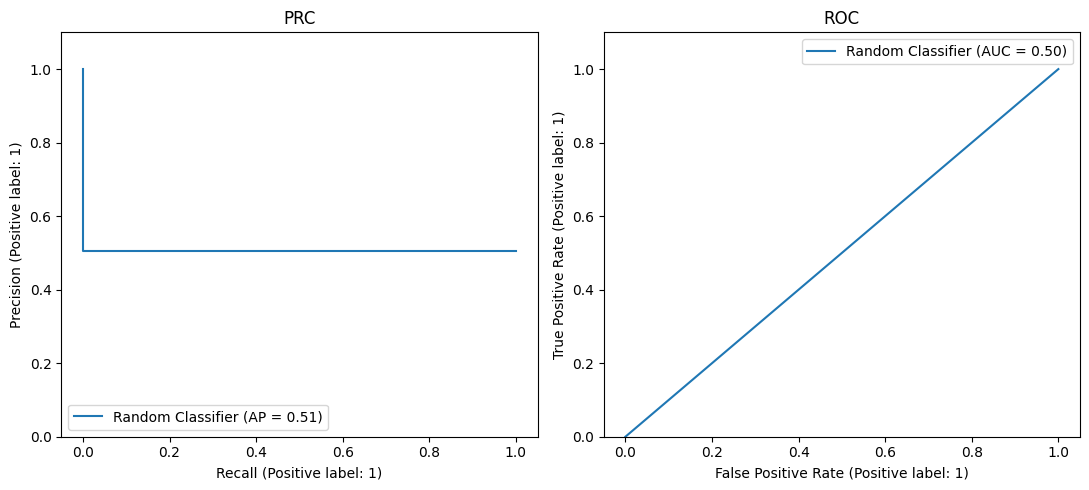

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer

In [8]:
gs_svc = GridSearchCV(LinearSVC(dual='auto'), {'C': np.logspace(-4, 3, 8)}, scoring=make_scorer(average_precision_score), n_jobs=-1, cv=5)
gs_svc.fit(X, y)

GridSearchCV(cv=5, estimator=LinearSVC(dual='auto'), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring=make_scorer(average_precision_score))

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

In [9]:
y_svc = gs_svc.decision_function(X_test)
# decision_function возвращает расстояние объектов до разделяющей гиперплоскости 

SVC metrics
AUC-PR: 0.8290
AUC-ROC: 0.8467


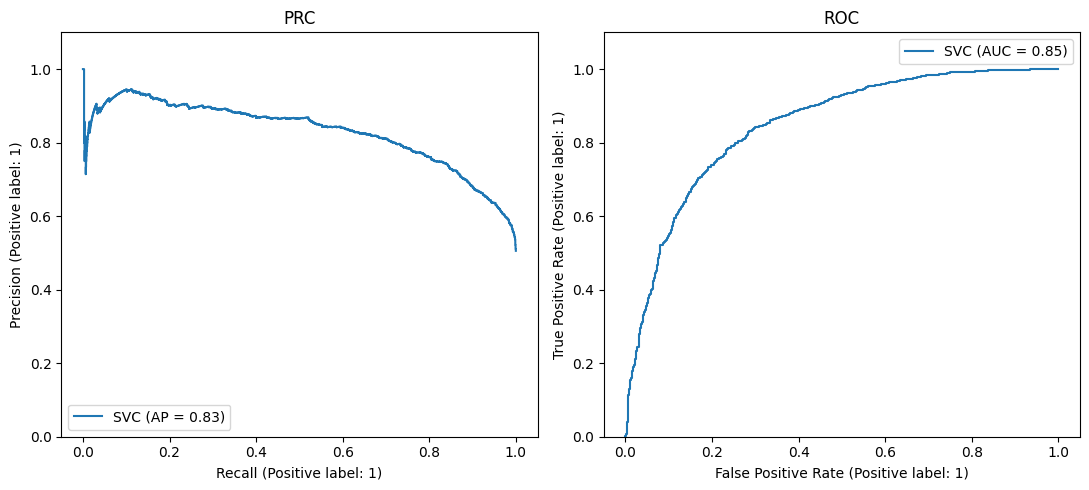

In [10]:
depict_pr_roc(y_test, y_svc, "SVC")

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

1. При увеличении порога в PRC precision высокий, однако recall очень низкий. В ROC при этом и TPR, и FPR низкие. Увеличение порога делает модель более "осторожной", сужая круг объектов, предсказанных как положительные. 
2. PRC не является монотонной. На рисунке выше она сначала убывает, потом возрастает, а затем вновь убывает. ROC в свою очередь монотонно возрастает.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
df_metrics.loc["SVC"] = [
    average_precision_score(y_test, y_svc),
    roc_auc_score(y_test, y_svc),
    gs_svc.best_params_["C"]
]

df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0000
SVC,0.829031,0.846679,0.0001


SVM справляется гораздо лучше

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.linear_model import LogisticRegression

gs_logit = GridSearchCV(LogisticRegression(), {'C': np.logspace(-4, 3, 8)}, scoring=make_scorer(average_precision_score), n_jobs=-1, cv=5)
gs_logit.fit(X, y)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring=make_scorer(average_precision_score))

LogisticRegression metrics
AUC-PR: 0.8295
AUC-ROC: 0.8483


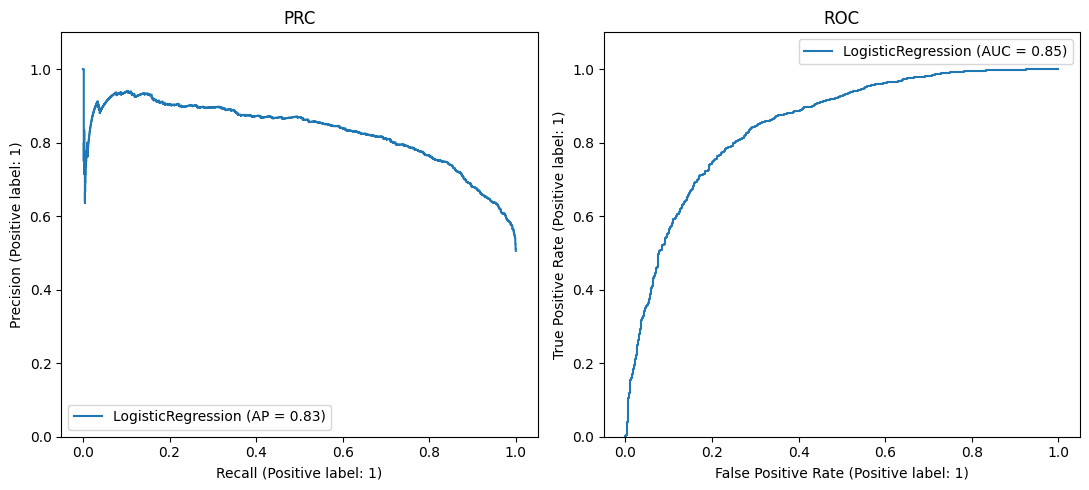

In [13]:
y_logit = gs_logit.predict_proba(X_test)[:, 1]
depict_pr_roc(y_test, y_logit, "LogisticRegression")

In [14]:
df_metrics.loc["LogisticRegression"] = [
    average_precision_score(y_test, y_logit),
    roc_auc_score(y_test, y_logit),
    gs_svc.best_params_["C"]
]

df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0000
SVC,0.829031,0.846679,0.0001
LogisticRegression,0.829488,0.848285,0.0001


Логистическая регрессия тоже лучше справляется с задачей, чем случайный классификатор

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
SVC metrics
AUC-PR: 0.8290
AUC-ROC: 0.8467
LogisticRegression metrics
AUC-PR: 0.8295
AUC-ROC: 0.8483


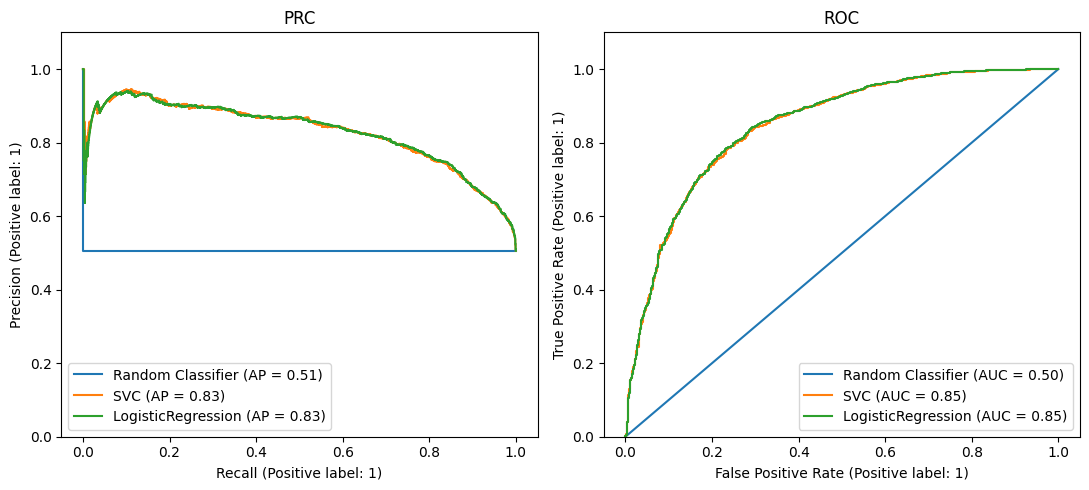

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, y_svc, "SVC", ax)
depict_pr_roc(y_test, y_logit, "LogisticRegression", ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Графики наглядно показывают, что метрики у этих классификаторов почти одинаковые. Разница лишь в 3-4 знаках после запятой

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [16]:
from sklearn.svm import SVC

In [17]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
model = SVC(kernel='linear').fit(X_train, y_train)

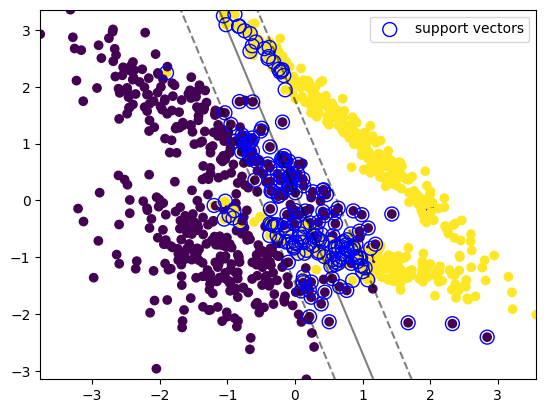

In [18]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(YY.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            x=model.support_vectors_[:, 0],
            y=model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** объекты, находящиеся внутри разделительной полосы или неверно классифицированные 

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [19]:
model = LogisticRegression().fit(X_train, y_train)

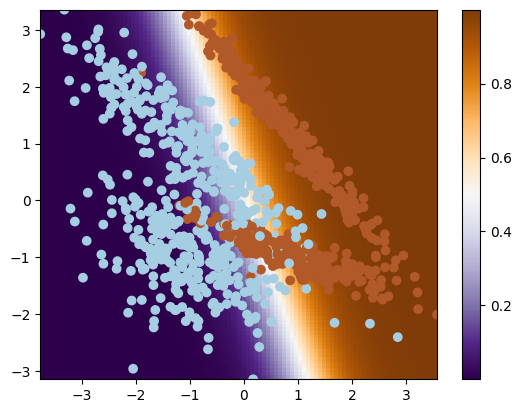

In [20]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(x=X[:, 0], y=X[:, 1], cmap=plt.cm.Paired, c=y)

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Этой областью является белая прямая, она является разделяющей прямой. Объекты, находящиеся справа от нее классифицированы как положительные ($p(y=+1|x) >= 0.5$), а объекты слева - как отрицательные ($p(y=+1|x) <= 0.5$).

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [21]:
def plot_calibration_curve(y_test, preds, color, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    
    plt.plot(bin_middle_points, bin_real_ratios, c=color, label=label)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
y_svc_scaled = MinMaxScaler().fit_transform(y_svc.reshape(-1, 1)).reshape(1, -1)[0]
y_svc_scaled

array([0.59137615, 0.16906936, 0.39893336, ..., 0.29649213, 0.66237018,
       0.73174256])

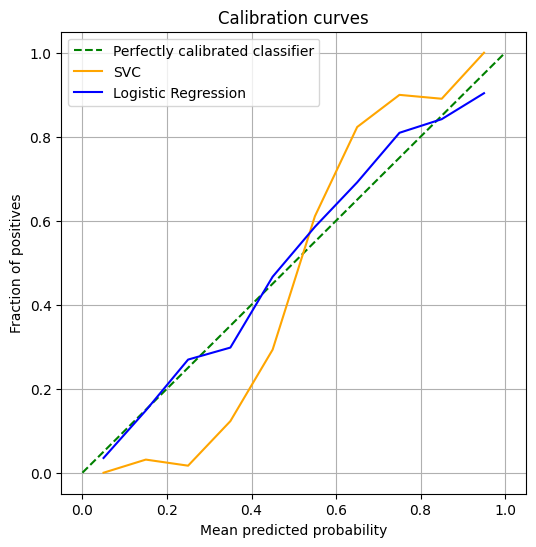

In [25]:
plt.figure(figsize=(6,6))
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")

plt.plot([0, 1], [0, 1], label="Perfectly calibrated classifier", linestyle='--', color='green')
plot_calibration_curve(y_test, y_svc_scaled, "orange", "SVC")
plot_calibration_curve(y_test, y_logit, "blue", "Logistic Regression")
plt.legend();

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Кривая для лог рега откалибрована хорошо, как и ожидалось. Кривая для SVM, на удивление, тоже получилась неплохой, однако всё равно она хуже, чем у лог рега.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [26]:
from sklearn.metrics import log_loss, brier_score_loss

In [27]:
logit_log_loss = log_loss(y_test, y_logit)
svc_log_loss = log_loss(y_test, y_svc_scaled)
logit_brier_loss = brier_score_loss(y_test, y_logit)
svc_brier_loss = brier_score_loss(y_test, y_svc_scaled)

df = pd.DataFrame({"LogLoss": [logit_log_loss, svc_log_loss], "BrierScore": [logit_brier_loss, svc_brier_loss]},
                  index=["Logistic Regression", "SVC"])
df

,LogLoss,BrierScore
Logistic Regression,0.485109,0.158372
SVC,0.557699,0.185863


У лог рега значения обеих функций потерь меньше, чем у SVM 

Изучите распределение ответов классификаторов при помощи гистограмм

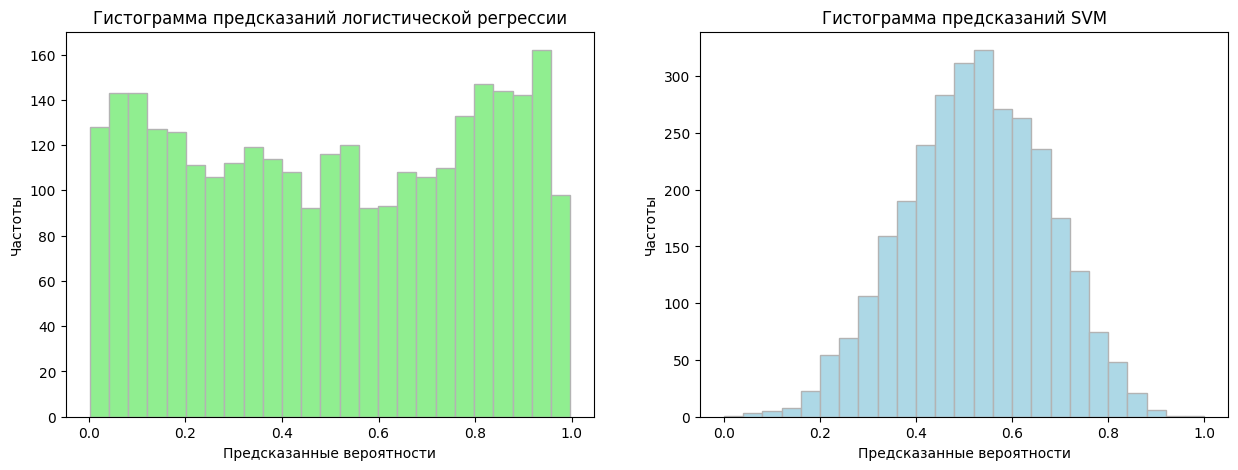

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))

ax[0].hist(y_logit, bins=25, color="lightgreen", edgecolor=".7")
ax[0].set_xlabel("Предсказанные вероятности")
ax[0].set_ylabel("Частоты")
ax[0].set_title("Гистограмма предсказаний логистической регрессии")

ax[1].hist(y_svc_scaled, bins=25, color="lightblue", edgecolor=".7")
ax[1].set_xlabel("Предсказанные вероятности")
ax[1].set_ylabel("Частоты")
ax[1].set_title("Гистограмма предсказаний SVM");

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У SVM нормальное распределение, а у логистической регрессии равномерное (с максимальными значениями по краям). Объяснить это можно так:  
LogReg обучается на предсказание вероятностей, в то время как SVM обучается на разграничение классов. Поэтому у LogReg меньше значений, в которых она не уверена (т.е. у которых вероятность 0.5).

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [29]:
from sklearn.calibration import CalibratedClassifierCV

model = LinearSVC(dual='auto')
calibrated_svc = CalibratedClassifierCV(model).fit(X_train, y_train)
y_cal_svc = calibrated_svc.predict_proba(X_test)[:, 1]

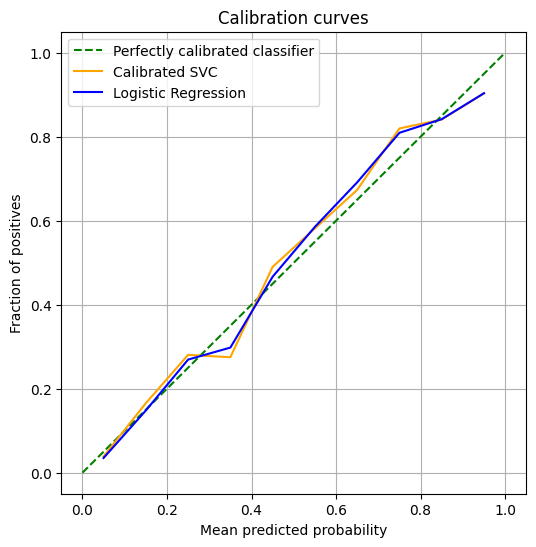

In [30]:
plt.figure(figsize=(6,6))
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")

plt.plot([0, 1], [0, 1], label="Perfectly calibrated classifier", linestyle='--', color='green')
plot_calibration_curve(y_test, y_cal_svc, "orange", "Calibrated SVC")
plot_calibration_curve(y_test, y_logit, "blue", "Logistic Regression")
plt.legend();

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да, калибровочная прямая SVM значительно улучшилась и приблизилась к лог регу

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [31]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [32]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [33]:
# Прочитаем датасет
df = pd.read_csv(path)

# Заменим пропуски категориальных переменных
categorical = df.select_dtypes('object').columns.tolist()
categorical.pop()  # удаляем таргет
numerical = df.select_dtypes(np.number).columns
df[categorical] = df[categorical].fillna('undefined')

# Отделим X и y
X = df.drop(columns='Purchased Bike')
y = df['Purchased Bike'].map({'Yes': 1, 'No': 0})

# Разделим на категориальные признаки и числовые
X_numerical = X[numerical].drop(columns='ID')
X_categorical = X[categorical]

В начале поработаем только с категориальными признаками

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [35]:
from sklearn.preprocessing import OrdinalEncoder

In [36]:
%%time

oe = OrdinalEncoder()
X_train_transformed = oe.fit_transform(X_train)

lr = LogisticRegression().fit(X_train_transformed, y_train)

CPU times: total: 15.6 ms
Wall time: 20.4 ms


In [37]:
X_test_transformed = oe.transform(X_test)
y_pred = lr.predict_proba(X_test_transformed)[:, 1]
average_precision_score(y_test, y_pred)

0.5883009320176316

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
%%time

ohe = OneHotEncoder()
X_train_transformed = ohe.fit_transform(X_train)

lr = LogisticRegression().fit(X_train_transformed, y_train)

CPU times: total: 62.5 ms
Wall time: 53.5 ms


In [40]:
X_test_transformed = ohe.transform(X_test)
y_pred = lr.predict_proba(X_test_transformed)[:, 1]
average_precision_score(y_test, y_pred)

0.666642757355176

Время кодирования и обучения увеличилось по сравнению с OrdinalEncoder, однако и качество выросло на 14%

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [41]:
class MeanTargetEncoder:
    def __init__(self, cat_features):
        self.cat_features = cat_features
        self.targets_means = {}
        
    def fit(self, X, y):
        X_t = X.copy()
        X_t['target'] = y
        for col in self.cat_features:
            gr = X_t.groupby(col)['target'].mean()
            self.targets_means[col] = {}
            for i in range(len(gr.index)):
                self.targets_means[col][gr.index[i]] = gr.values[i]
    
    def transform(self, X):
        X_t = X.copy()
        for col in X_t.columns:
            X_t[col] = X_t[col].map(self.targets_means[col])
        return X_t

In [42]:
%%time

mte = MeanTargetEncoder(X_train.columns)
mte.fit(X_train, y_train)
X_train_transformed = mte.transform(X_train)

lr = LogisticRegression().fit(X_train_transformed, y_train)
X_train_transformed.head()

CPU times: total: 31.2 ms
Wall time: 42.5 ms


,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079
110,0.552632,0.504155,0.437186,0.482759,0.489270,0.535581,0.488372
902,0.552632,0.463158,0.529915,0.478947,0.478599,0.566667,0.430079
15,0.552632,0.504155,0.466165,0.482759,0.478599,0.535581,0.488372


In [43]:
X_test_transformed = mte.transform(X_test)
y_pred = lr.predict_proba(X_test_transformed)[:, 1]
average_precision_score(y_test, y_pred)

0.6575408792625901

Время обучения примерно такое же, как при OHE, а значение метрики даже немного ухудшилось

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [45]:
class FastMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
        self.targets_means = {}

    def fit(self, X, y):
        X_t = X.copy()
        X_t['target'] = y
        self.targets_means = {col: X_t.groupby(col)['target'].mean() for col in self.cat_features}
        return self  # Это нужно, чтобы работал ColumnTransformer
    
    def transform(self, X):
        X_t = X.copy()
        for col in X_t.columns:
            X_t[col] = X_t[col].map(self.targets_means[col])
        return X_t

In [46]:
%%time

fmte_transformer = ColumnTransformer(transformers=[
    ('fmte', FastMeanTargetEncoder(X_train.columns), X_train.columns)
])

pipeline = Pipeline([
    ('fmte_transformer', fmte_transformer),
    ('logit', LogisticRegression())
])

pipeline.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 50.5 ms


Pipeline(steps=[('fmte_transformer',
                 ColumnTransformer(transformers=[('fmte',
                                                  FastMeanTargetEncoder(cat_features=Index(['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region'],
      dtype='object')),
                                                  Index(['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region'],
      dtype='object'))])),
                ('logit', LogisticRegression())])

In [47]:
y_pred = pipeline.predict_proba(X_test)[:, 1]
average_precision_score(y_test, y_pred)

0.6575408792625901

Время почти не изменилось, метрика тоже

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [48]:
class NoiseMeanTargetEncoder:
    def __init__(self, cat_features):
        self.cat_features = cat_features
        self.noise_max = 0.02
        self.random_state = 18
        self.targets_means = {}
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        X_t = X.copy()
        X_t['target'] = y
        for col in self.cat_features:
            gr = X_t.groupby(col)['target'].mean()
            self.targets_means[col] = {}
            for i in range(len(gr.index)):
                noise = np.random.normal(0, self.noise_max)
                self.targets_means[col][gr.index[i]] = gr.values[i] + noise
    
    def transform(self, X):
        X_t = X.copy()
        for col in X_t.columns:
            X_t[col] = X_t[col].map(self.targets_means[col])
        return X_t

In [49]:
%%time

nmte = NoiseMeanTargetEncoder(X_train.columns)
nmte.fit(X_train, y_train)
X_train_transformed = nmte.transform(X_train)

lr = LogisticRegression().fit(X_train_transformed, y_train)

CPU times: total: 62.5 ms
Wall time: 44.5 ms


In [50]:
X_test_transformed = nmte.transform(X_test)
y_pred = lr.predict_proba(X_test_transformed)[:, 1]
average_precision_score(y_test, y_pred)

0.6650358241026758

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** При random_state=18 качество немного выросло, однако при других random_state качество может быть как лучше, так и хуже, => добавление  шума не помогло

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [51]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [52]:
class SmoothMeanTargetEncoder:
    def __init__(self, cat_features, C=10):
        self.cat_features = cat_features
        self.targets_means = {}
        self.C = C
        
    def fit(self, X, y):
        X_t = X.copy()
        X_t['target'] = y
        global_mean = y.mean()
        for col in self.cat_features:
            gr = X_t.groupby(col)['target']
            gr_sum = gr.sum()  # Число положительных таргетов у каждой категории
            gr_count = gr.count()  # Количество объектов каждой категории
            self.targets_means[col] = {}
            for i in range(len(gr_sum.index)):
                self.targets_means[col][gr_sum.index[i]] = (gr_sum.values[i] + self.C * global_mean) / (gr_count.values[i] + self.C)
    
    def transform(self, X):
        X_t = X.copy()
        for col in X_t.columns:
            X_t[col] = X_t[col].map(self.targets_means[col])
        return X_t

In [53]:
%%time

smte = SmoothMeanTargetEncoder(X_train.columns, 6)
smte.fit(X_train, y_train)
X_train_transformed = smte.transform(X_train)

lr = LogisticRegression().fit(X_train_transformed, y_train)

CPU times: total: 31.2 ms
Wall time: 37 ms


In [54]:
X_test_transformed = smte.transform(X_test)
y_pred = lr.predict_proba(X_test_transformed)[:, 1]
average_precision_score(y_test, y_pred)

0.6731078174958476

В целом, уже при дефолтном значении C значение метрики было > OHE, но при C = 6 получилось увеличить метрику ещё на одну тысячную

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [55]:
X_numerical.isna().sum()

Income      6
Children    8
Cars        9
Age         8
dtype: int64

In [56]:
X_numerical.fillna(X_numerical.mean(), inplace=True)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [57]:
X_numerical.nunique()

Income      17
Children     7
Cars         6
Age         54
dtype: int64

In [58]:
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical, y, test_size=0.25, random_state=777, stratify=y)

In [59]:
best_auc_pr = 0
best_c = 0
for c in range(1, 101):
    smte = SmoothMeanTargetEncoder(X_train_num.columns, c)
    smte.fit(X_train_num, y_train)
    X_train_transformed = smte.transform(X_train_num)
    
    lr = LogisticRegression().fit(X_train_transformed, y_train)
    
    X_test_transformed = smte.transform(X_test_num)
    y_pred = lr.predict_proba(X_test_transformed)[:, 1]
    curr_auc_pr = average_precision_score(y_test, y_pred)
    if curr_auc_pr > best_auc_pr:
        best_auc_pr = curr_auc_pr
        best_c = c

print("Best AUC-PR:", best_auc_pr, sep="\t")
print("Best C:", best_c, sep="\t")

Best AUC-PR:	0.6715221880844295
Best C:	85


Значение метрики незначительно хуже, чем при использовании только категориальных признаков

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Значительным плюсом счётчиков является малое количество признаков после их применения. Из минусов можно отметить переобучение, однако с ним можно бороться.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [60]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

# import wget
# wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 'adult.data')

In [61]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5926,42,Private,259643,Masters,14,Divorced,Prof-specialty,Not-in-family,White,Male,4650,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['income']), df['income'],
                                                    test_size=0.25, random_state=777, stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [63]:
cat = X_train.select_dtypes('object').columns
num = X_train.select_dtypes('number').columns

In [64]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train[cat]).shape[1] - X_train.shape[1]

88

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaling', StandardScaler(), num)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logit', LogisticRegression(max_iter=300))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
curr_best_auc_pr = average_precision_score(y_test, y_pred)
curr_best_auc_pr

0.7672073579312724

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.5, 
                                                      random_state=777, stratify=y_train)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [68]:
from sklearn.feature_selection import SelectFromModel

In [69]:
coefs = np.sort(np.abs(pipeline.named_steps['logit'].coef_[0]))

In [70]:
%%time

threshold = coefs[-40]
selector = SelectFromModel(pipeline.named_steps['logit'], 
                           threshold=threshold).fit(column_transformer.transform(X_train), y_train)

pipeline = Pipeline([
    ('ohe_and_scaling', column_transformer),
    ('selector', selector),
    ('logit', LogisticRegression(max_iter=300))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

new_best_auc_pr = average_precision_score(y_test, y_pred)
new_best_auc_pr

CPU times: total: 1.53 s
Wall time: 1.57 s


0.73133742518201

In [71]:
selector.get_support()

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
        True,  True, False, False,  True,  True,  True,  True, False,
        True, False, False, False,  True,  True, False,  True,  True,
       False, False, False, False,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False,  True,  True, False, False])

In [72]:
selected_features_ohe_scaling = pipeline.named_steps['ohe_and_scaling'].get_feature_names_out()[selector.get_support()]
print('Selected Features:')
print(selected_features_ohe_scaling)

Selected Features:
['ohe__workclass_ Federal-gov' 'ohe__education_ 5th-6th'
 'ohe__education_ Preschool' 'ohe__marital-status_ Divorced'
 'ohe__marital-status_ Married-AF-spouse'
 'ohe__marital-status_ Married-civ-spouse'
 'ohe__marital-status_ Married-spouse-absent'
 'ohe__marital-status_ Never-married' 'ohe__marital-status_ Separated'
 'ohe__occupation_ Exec-managerial' 'ohe__occupation_ Farming-fishing'
 'ohe__occupation_ Other-service' 'ohe__occupation_ Priv-house-serv'
 'ohe__occupation_ Prof-specialty' 'ohe__occupation_ Protective-serv'
 'ohe__occupation_ Tech-support' 'ohe__relationship_ Other-relative'
 'ohe__relationship_ Own-child' 'ohe__relationship_ Wife'
 'ohe__race_ Amer-Indian-Eskimo' 'ohe__sex_ Female' 'ohe__sex_ Male'
 'ohe__native-country_ Cambodia' 'ohe__native-country_ Canada'
 'ohe__native-country_ Columbia' 'ohe__native-country_ Cuba'
 'ohe__native-country_ Dominican-Republic' 'ohe__native-country_ Ecuador'
 'ohe__native-country_ France' 'ohe__native-country_ Germ

Изменилось ли качество? Как?

Качество упало на 4% и времени всё это заняло больше

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [73]:
ohe_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat)
])

pipeline = Pipeline(steps=[
    ('ohe', ohe_transformer),
    ('logit', LogisticRegression(max_iter=300))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
curr_best_auc_pr_ohe = average_precision_score(y_test, y_pred)
curr_best_auc_pr_ohe

0.68558041230876

Сразу видим, как сильно упало качество без масштабирования

In [74]:
coefs = np.sort(np.abs(pipeline.named_steps['logit'].coef_[0]))

In [75]:
%%time

threshold = coefs[-40]
selector = SelectFromModel(pipeline.named_steps['logit'], 
                           threshold=threshold).fit(ohe_transformer.transform(X_train), y_train)

pipeline = Pipeline([
    ('ohe', ohe_transformer),
    ('selector', selector),
    ('logit', LogisticRegression(max_iter=300))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

new_best_auc_pr_ohe = average_precision_score(y_test, y_pred)
new_best_auc_pr_ohe

CPU times: total: 1.2 s
Wall time: 1.26 s


0.6476180510540059

In [76]:
selected_features_ohe_only = pipeline.named_steps['ohe'].get_feature_names_out()[selector.get_support()]
print('Selected OHE Features:')
print(selected_features_ohe_only)

Selected OHE Features:
['ohe__workclass_ Federal-gov' 'ohe__education_ 10th'
 'ohe__education_ 11th' 'ohe__education_ 1st-4th'
 'ohe__education_ 5th-6th' 'ohe__education_ 7th-8th' 'ohe__education_ 9th'
 'ohe__education_ Bachelors' 'ohe__education_ Doctorate'
 'ohe__education_ Masters' 'ohe__education_ Preschool'
 'ohe__education_ Prof-school' 'ohe__marital-status_ Married-AF-spouse'
 'ohe__marital-status_ Married-civ-spouse'
 'ohe__marital-status_ Never-married' 'ohe__marital-status_ Separated'
 'ohe__occupation_ Exec-managerial' 'ohe__occupation_ Farming-fishing'
 'ohe__occupation_ Other-service' 'ohe__occupation_ Priv-house-serv'
 'ohe__occupation_ Prof-specialty' 'ohe__occupation_ Protective-serv'
 'ohe__occupation_ Tech-support' 'ohe__relationship_ Not-in-family'
 'ohe__relationship_ Other-relative' 'ohe__relationship_ Own-child'
 'ohe__relationship_ Wife' 'ohe__sex_ Female' 'ohe__sex_ Male'
 'ohe__native-country_ Cambodia' 'ohe__native-country_ Canada'
 'ohe__native-country_ Colum

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [77]:
column_transformer = ColumnTransformer([
    ('categorical', Pipeline([
        ('ohe', OneHotEncoder(sparse_output=False)),
        ('scaling', StandardScaler())
    ]), cat),
    ('numerical', StandardScaler(), num)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logit', LogisticRegression(max_iter=300))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
curr_best_auc_pr = average_precision_score(y_test, y_pred)
curr_best_auc_pr

0.7624971262712616

Здесь качество не сильно хуже, чем при масштабировании только числовых признаков

In [78]:
coefs = np.sort(np.abs(pipeline.named_steps['logit'].coef_[0]))

In [79]:
%%time

threshold = coefs[-40]
selector = SelectFromModel(pipeline.named_steps['logit'], 
                           threshold=threshold).fit(column_transformer.transform(X_train), y_train)

pipeline = Pipeline([
    ('ohe_and_scaling', column_transformer),
    ('selector', selector),
    ('logit', LogisticRegression(max_iter=300))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

new_best_auc_pr = average_precision_score(y_test, y_pred)
new_best_auc_pr

CPU times: total: 4.02 s
Wall time: 1.6 s


0.7549492349909911

In [80]:
selected_features_final = pipeline.named_steps['ohe_and_scaling'].get_feature_names_out()[selector.get_support()]
print('Selected Features With Scaling Categorical Features:')
print(selected_features_final)

Selected Features With Scaling Categorical Features:
['categorical__workclass_ Federal-gov'
 'categorical__workclass_ Self-emp-not-inc'
 'categorical__workclass_ Without-pay' 'categorical__education_ 11th'
 'categorical__education_ Bachelors' 'categorical__education_ Doctorate'
 'categorical__education_ HS-grad' 'categorical__education_ Masters'
 'categorical__education_ Preschool' 'categorical__education_ Prof-school'
 'categorical__marital-status_ Divorced'
 'categorical__marital-status_ Married-civ-spouse'
 'categorical__marital-status_ Married-spouse-absent'
 'categorical__marital-status_ Never-married'
 'categorical__marital-status_ Separated'
 'categorical__occupation_ Exec-managerial'
 'categorical__occupation_ Farming-fishing'
 'categorical__occupation_ Other-service'
 'categorical__occupation_ Priv-house-serv'
 'categorical__occupation_ Prof-specialty'
 'categorical__occupation_ Protective-serv'
 'categorical__relationship_ Husband'
 'categorical__relationship_ Not-in-family'


In [81]:
common_features1 = set()
common_features2 = set()

for feature in selected_features_ohe_scaling:
    common_features1.add(feature.split('__')[1])
for feature in selected_features_final:
    common_features2.add(feature.split('__')[1])

print('Количество общих признаков:', len(common_features1 & common_features2))
common_features1 & common_features2

Количество общих признаков: 25


{'capital-gain',
 'education-num',
 'education_ Preschool',
 'marital-status_ Divorced',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'native-country_ Columbia',
 'native-country_ Dominican-Republic',
 'native-country_ Hong',
 'native-country_ Japan',
 'native-country_ Puerto-Rico',
 'occupation_ Exec-managerial',
 'occupation_ Farming-fishing',
 'occupation_ Other-service',
 'occupation_ Priv-house-serv',
 'occupation_ Prof-specialty',
 'occupation_ Protective-serv',
 'relationship_ Other-relative',
 'relationship_ Own-child',
 'relationship_ Wife',
 'sex_ Female',
 'sex_ Male',
 'workclass_ Federal-gov'}

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Корреляция - это степень линейной зависимости двух случайных величин. Я бы отобрал признаки по наибольшей абсолютной корреляции

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [82]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False), cat),
    ('scaling', StandardScaler(), num)
])

X_train_transformed = column_transformer.fit_transform(X_train, y_train)
X_test_transformed = column_transformer.transform(X_test)

col_names = column_transformer.named_transformers_['ohe'].get_feature_names_out(cat).tolist() + num.tolist()
new_df_train = pd.DataFrame(X_train_transformed, columns=col_names)
new_df_test = pd.DataFrame(X_test_transformed, columns=col_names)
new_df_train['target'] = y_train
correlations = new_df_train.corr()['target'].drop('target')

selected_columns = correlations.abs().sort_values(ascending=False).index[:40]

model = LogisticRegression(max_iter=300).fit(new_df_train.drop(columns='target')[selected_columns], y_train)
y_pred = model.predict_proba(new_df_test[selected_columns])[:, 1]

new_best_auc_pr = average_precision_score(y_test, y_pred)
new_best_auc_pr

CPU times: total: 2.39 s
Wall time: 1.5 s


0.5786477111921476

Не быстро, да и качество очень сильно упало

В качестве еще одной функции можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [83]:
def t_j(X, y):
    mu_pos = np.mean(X[y == 1], axis=0)
    mu_neg =  np.mean(X[y == 0], axis=0)
    sigma2_pos = np.var(X[y == 1], axis=0)
    sigma2_neg = np.var(X[y == 0], axis=0)
    n_pos = X[y == 1].shape[0]
    n_neg = X[y == 0].shape[0]

    return np.abs(mu_pos - mu_neg) / np.sqrt((n_pos * sigma2_pos + n_neg * sigma2_neg) / (n_pos + n_neg))

In [84]:
%%time

t_values = t_j(X_train_transformed, y_train)
threshold = np.sort(t_values)[-40]
X_train_transformed = X_train_transformed[:, t_values >= threshold]
X_test_transformed = X_test_transformed[:, t_values >= threshold]

model = LogisticRegression(max_iter=300).fit(X_train_transformed, y_train)
y_pred = model.predict_proba(X_test_transformed)[:, 1]

new_best_auc_pr = average_precision_score(y_test, y_pred)
new_best_auc_pr

CPU times: total: 1.27 s
Wall time: 632 ms


0.7633257051934631

Этот способ быстрее и лучше, чем простой подсчёт корреляции

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [85]:
# your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [86]:
# your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Отбор признаков с помощью встроенных методов (в нашем случае это использование весов лог рега) даёт наилучшее качество и работает быстрее всего. Метод t-статистики тоже выдает отличный результат и работает довольно быстро. При использовании корреляции между каждым признаком и таргетом получается плохое качество метрики, да и работает этот способ не очень быстро

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [87]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

# wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip', 'bank-additional.zip')
# !unzip bank-additional.zip

df = pd.read_csv('bank-additional-full.csv', sep=';')

In [88]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [89]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [90]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    business_metrics=False,
    random_profit=False,
    high_recall=False
):
    metrics = []
    
    categorical = X.select_dtypes('object').columns
    numerical = X.select_dtypes('number').columns
    
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        col_tr = ColumnTransformer([('ohe', OneHotEncoder(), categorical), 
                                    ('scaling', StandardScaler(), numerical)])

        pipeline = Pipeline(steps=[
            ('ohe_and_scaling', col_tr),
            ('logit', LogisticRegression(max_iter=500))
        ])
        
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)[:, 1] > 0.15 if high_recall else pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        if business_metrics:
            call_center_salary = y_pred.sum() * 2
            client_profit = np.random.uniform(0, 20) if random_profit else 10
            profit = (y_test & y_pred).sum() * client_profit - call_center_salary

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "auc-roc": roc_auc_score(y_test, y_pred)
            "auc-roc": roc_auc_score(y_test, y_pred_proba)
        }
        if business_metrics:
            metric_dict['profit'] = profit
            metric_dict['call_center_salary'] = call_center_salary
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [91]:
metrics = cross_validate(X, y, shuffle=True, random_state=17)
metrics

,auc-roc
0,0.799385
1,0.790513
2,0.790389
3,0.792242
4,0.787831


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [92]:
metrics_with_profit = cross_validate(X, y, shuffle=True, random_state=17, business_metrics=True)
metrics_with_profit

,auc-roc,profit,call_center_salary
0,0.799385,1652,678
1,0.790513,1452,618
2,0.790389,1394,666
3,0.792242,1458,662
4,0.787831,1496,604


In [93]:
metrics_with_profit['profit'].mean()

1490.4

In [94]:
metrics_with_profit['profit'].std()

97.42073701219881

In [95]:
metrics_with_profit['call_center_salary'].mean()

645.6

In [96]:
metrics_with_profit.corr()["profit"]["auc-roc"] # да, метрика пропорциональна бизнес метрике

0.8052894143848832

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [97]:
metrics_with_profit_random = cross_validate(X, y, shuffle=True, random_state=17, 
                                            business_metrics=True, random_profit=True)
metrics_with_profit_random

,auc-roc,profit,call_center_salary
0,0.799385,700.206003,678
1,0.790513,1683.860351,618
2,0.790389,3228.888112,666
3,0.792242,907.400560,662
4,0.787831,364.142049,604


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [98]:
def optimal_C(X, y):
    best_c = 0
    best_profit = 0
    mean_profits, mean_profits_var = [], []
    
    categorical = X.select_dtypes('object').columns
    numerical = X.select_dtypes('number').columns
    
    kf = KFold(n_splits=5, random_state=17, shuffle=True)

    for c in np.logspace(-3, 3, 8):
        curr_profits = []
        for train_index, test_index in kf.split(X):
            col_tr = ColumnTransformer([('ohe', OneHotEncoder(), categorical), 
                                        ('scaling', StandardScaler(), numerical)])
    
            pipeline = Pipeline(steps=[
                ('ohe_and_scaling', col_tr),
                ('logit', LogisticRegression(C=c, max_iter=500))
            ])
            
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            call_center_salary = y_pred.sum() * 2
            client_profit = np.random.uniform(0, 20)
            profit = (y_test & y_pred).sum() * client_profit - call_center_salary
            curr_profits.append(profit)

        mean_profits.append(np.mean(curr_profits))
        mean_profits_var.append(np.std(curr_profits))
        if np.mean(curr_profits) > best_profit:
            best_profit = np.mean(curr_profits)
            best_c = c

    plt.figure(figsize=(10, 5))
    plt.errorbar(np.log10(np.logspace(-3, 3, 8)), mean_profits, mean_profits_var, fmt='o-', ecolor='lightblue')
    plt.title('График зависимости случайной прибыли от параметра регуляризации', fontsize=16)
    plt.xlabel('log C', fontsize=14)
    plt.ylabel('Прибыль', fontsize=14)
    plt.show()
    
    return best_c, best_profit

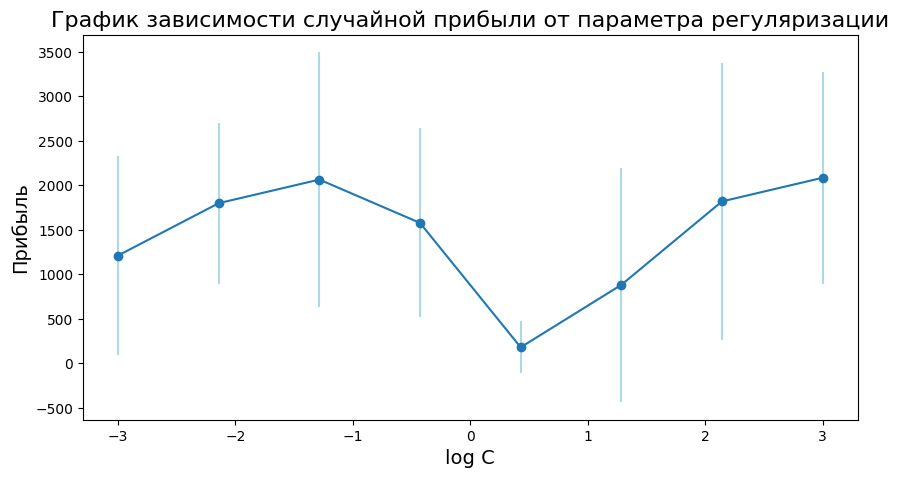

Максимальная прибыль:			2086.06
Лучший коэффициент регуляризации:	1000.00


In [99]:
best_c, best_profit = optimal_C(X, y)
print(f"Максимальная прибыль:\t\t\t{best_profit:.2f}\nЛучший коэффициент регуляризации:\t{best_c:.2f}")

Выигрыш получить не удалось, тут абсолютный рандом

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

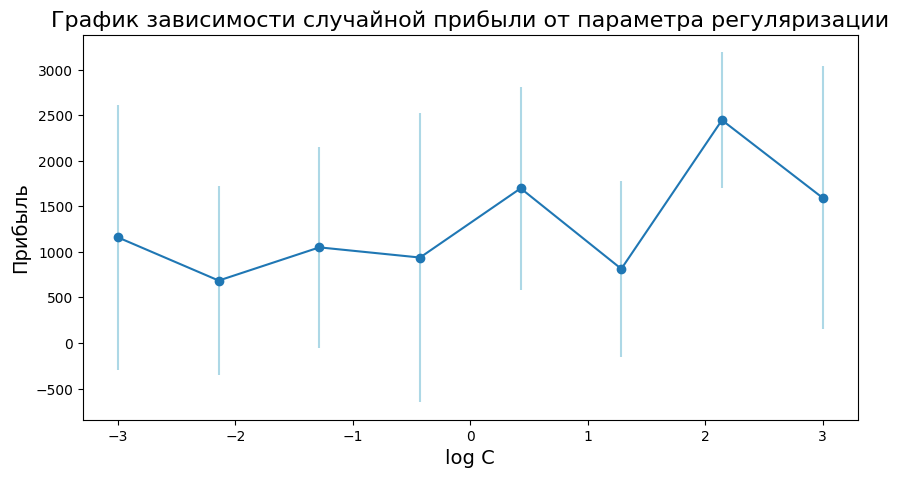

Максимальная прибыль:			2447.28
Лучший коэффициент регуляризации:	138.95


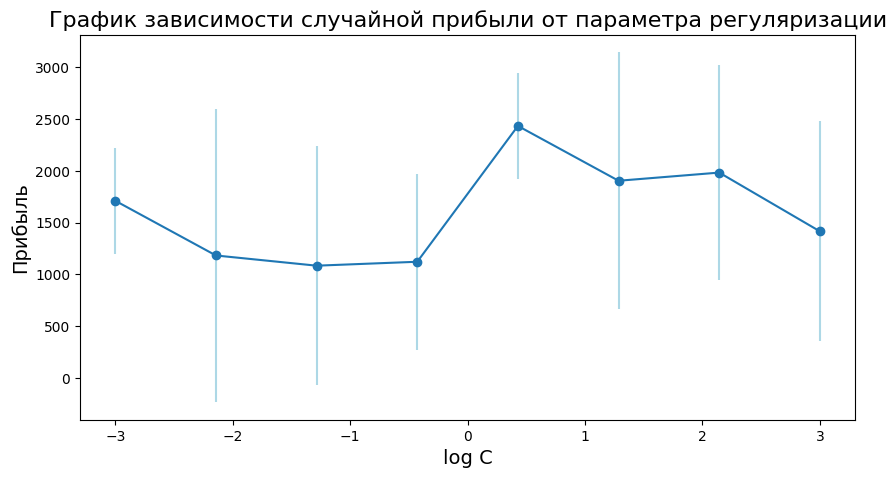

Максимальная прибыль:			2432.32
Лучший коэффициент регуляризации:	2.68


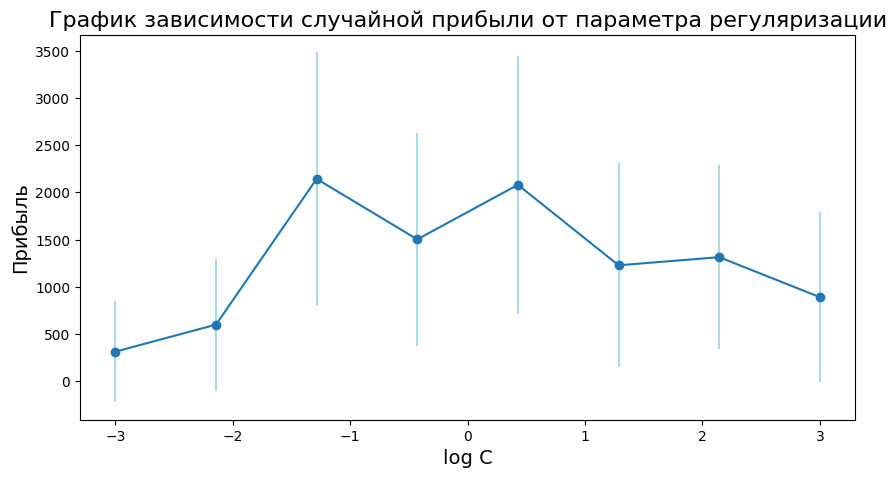

Максимальная прибыль:			2143.78
Лучший коэффициент регуляризации:	0.05


In [100]:
for _ in range(3):
    best_c, best_profit = optimal_C(X, y)
    print(f"Максимальная прибыль:\t\t\t{best_profit:.2f}\nЛучший коэффициент регуляризации:\t{best_c:.2f}")

Как мы видим, коэффициенты каждый раз получаются разные, трудно уловить в них какую-то закономерность

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Для бизнеса важнее будет recall, потому что лучше уж мы позвоним большему числу клиентов и сможем заработать на них больше денег (т.к. звонки не дорогие), чем будем звонить только тем клиентам, в чьём желании приобрести продукт мы уверены



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [101]:
def optimal_threshold(X, y):
    best_threshold = 0
    best_profit = 0
    mean_profits = []
    param_grid = np.arange(0, 1, 0.01)
    
    categorical = X.select_dtypes('object').columns
    numerical = X.select_dtypes('number').columns
    
    kf = KFold(n_splits=5, random_state=17, shuffle=True)

    for threshold in param_grid:
        curr_profits = []
        for train_index, test_index in kf.split(X):
            col_tr = ColumnTransformer([('ohe', OneHotEncoder(), categorical), 
                                        ('scaling', StandardScaler(), numerical)])
    
            pipeline = Pipeline(steps=[
                ('ohe_and_scaling', col_tr),
                ('logit', LogisticRegression(max_iter=500))
            ])
            
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict_proba(X_test)[:, 1] > threshold

            call_center_salary = y_pred.sum() * 2
            client_profit = np.random.uniform(0, 20)
            profit = (y_test & y_pred).sum() * client_profit - call_center_salary
            curr_profits.append(profit)

        mean_profits.append(np.mean(curr_profits))
        if np.mean(curr_profits) > best_profit:
            best_profit = np.mean(curr_profits)
            best_threshold = threshold

    plt.figure(figsize=(10, 5))
    plt.plot(param_grid, mean_profits, marker='o')
    plt.scatter(best_threshold, best_profit, color='red', s=100, label='Максимальная прибыль')
    plt.title('График зависимости случайной прибыли от порога', fontsize=16)
    plt.xlabel('Порог', fontsize=14)
    plt.ylabel('Прибыль', fontsize=14)
    plt.legend()
    plt.show()
    
    return best_threshold, best_profit

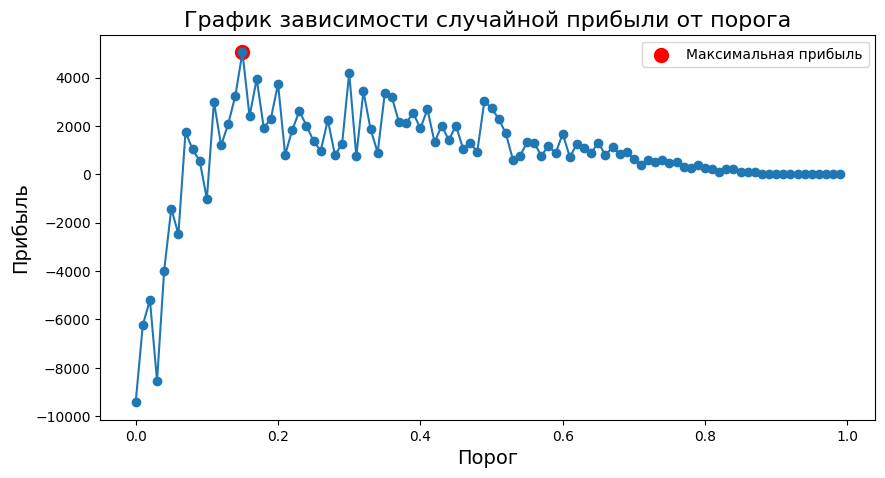

Максимальная прибыль:	5046.19
Лучший порог:		0.15


In [102]:
best_threshold, best_profit = optimal_threshold(X, y)
print(f"Максимальная прибыль:\t{best_profit:.2f}\nЛучший порог:\t\t{best_threshold:.2f}")

Recall сильно связан с профитом. Нам удалось достичь самой большой прибыли благодаря низкому порогу

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

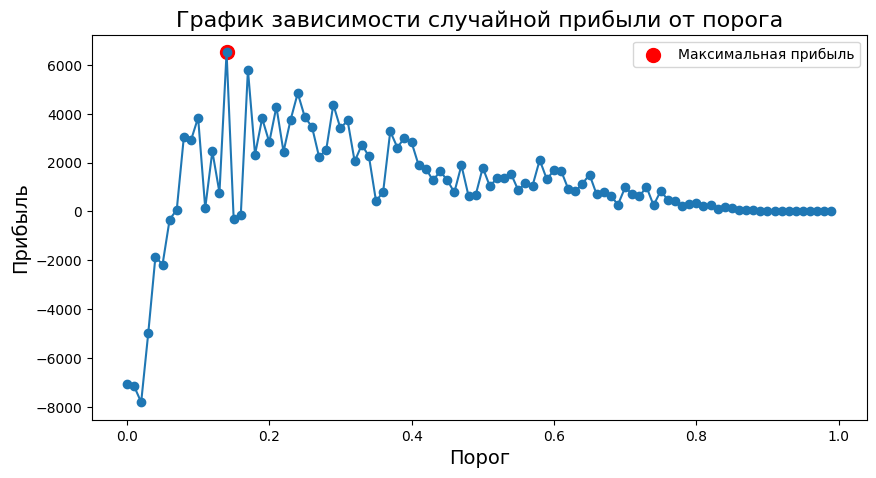

Максимальная прибыль:	6510.31
Лучший порог:		0.14


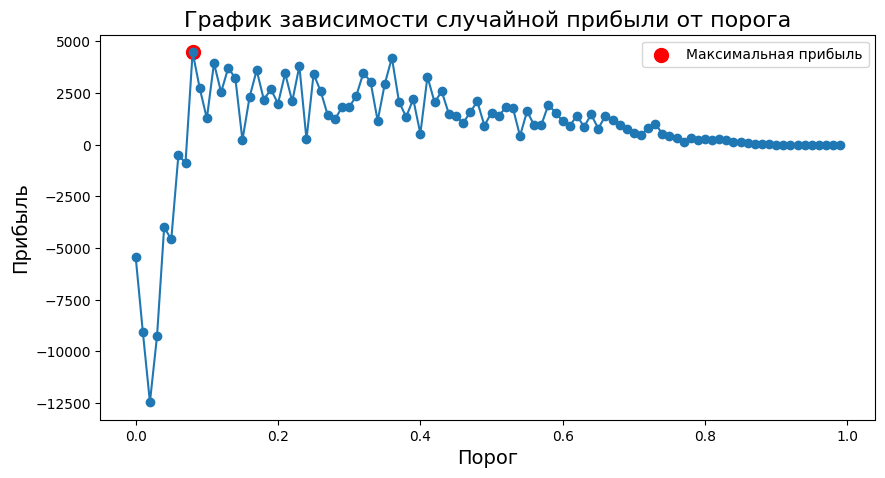

Максимальная прибыль:	4470.78
Лучший порог:		0.08


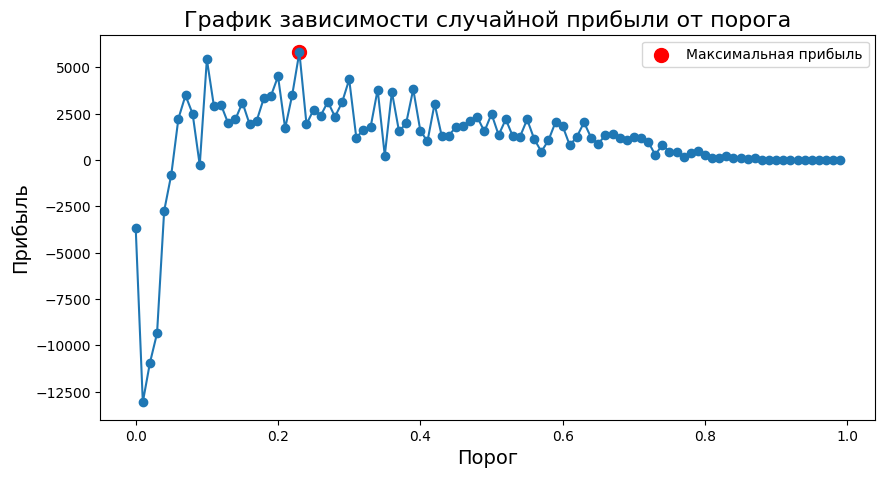

Максимальная прибыль:	5812.70
Лучший порог:		0.23


In [103]:
for _ in range(3):
    best_threshold, best_profit = optimal_threshold(X, y)
    print(f"Максимальная прибыль:\t{best_profit:.2f}\nЛучший порог:\t\t{best_threshold:.2f}")

__Ответ:__ Порог выбирается примерно вокруг значения 0.15.  
Это логично, потому что при большом пороге мы будем многих клиентов пропускать, хотя звонки не такие уж дорогие. Однако звонки всё же не бесплатные, поэтому всех подряд обзванивать при нулевом пороге мы тоже не можем.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [104]:
from scipy.stats import ttest_rel

In [105]:
default_metrics = cross_validate(X, y, random_state=17, shuffle=True,
                                 business_metrics=True, random_profit=True)
default_mean = default_metrics['profit'].mean()
default_std = default_metrics['profit'].std()

optimized_metrics = cross_validate(X, y, random_state=17, shuffle=True, 
                                   business_metrics=True, random_profit=True, high_recall=True)
optimized_mean = optimized_metrics['profit'].mean()
optimized_std = optimized_metrics['profit'].std()

print(f"Оптимизированная модель: Средний профит = {optimized_mean}, Стандартное отклонение профита = {optimized_std}")
print(f"Дефолтная модель: Средний профит = {default_mean}, Стандартное отклонение профита = {default_std}")

Оптимизированная модель: Средний профит = 3486.6738874527628, Стандартное отклонение профита = 3191.0877810153834
Дефолтная модель: Средний профит = 2144.4652753346586, Стандартное отклонение профита = 1643.000349489523


In [106]:
t_stat, p_value = ttest_rel(optimized_metrics['profit'], default_metrics['profit'])

if p_value < 0.05:
    print(f"Разница значима (p-value = {p_value:.4f}), => оптимизированная модель действительно лучше.")
else:
    print(f"Разница незначима (p-value = {p_value:.4f}), => нет доказательств, что оптимизированная модель лучше.")

Разница незначима (p-value = 0.4447), => нет доказательств, что оптимизированная модель лучше.


Думаю, такой результат связан с тем, что у оптимизированной модели очень высокое СКО, несмотря на высокое среднее значение

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [107]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
X = pd.read_csv(path)[features + [target]]
y = LabelEncoder().fit_transform(X[target])

cat = ["Marital status", "Course", "Nacionality"]
num = ["Gender", "Age at enrollment"]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns="Target"), y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [111]:
col_tr = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), cat), 
                            ('scaling', StandardScaler(), num)])

pipeline_ovr = Pipeline(steps=[
    ('ohe_and_scaling', col_tr),
    ('logit', LogisticRegression(multi_class='ovr', max_iter=10000))
])

pipeline_ovo = Pipeline(steps=[
    ('ohe_and_scaling', col_tr),
    ('logit', LogisticRegression(multi_class='multinomial', max_iter=10000))
])

In [112]:
%%time
pipeline_ovr.fit(X_train, y_train)
y_pred_ovr = pipeline_ovr.predict(X_test)
y_propa_ovr = pipeline_ovr.predict_proba(X_test)

CPU times: total: 109 ms
Wall time: 124 ms


In [113]:
%%time
pipeline_ovo.fit(X_train, y_train)
y_pred_ovo = pipeline_ovo.predict(X_test)
y_propa_ovo = pipeline_ovo.predict_proba(X_test)

CPU times: total: 125 ms
Wall time: 125 ms


В данном примере время не сильно отличается. Предположу, что это связано с небольшим количеством классов

In [114]:
from sklearn.metrics import f1_score

In [115]:
X["Target"].value_counts()
# Классы более-менее сбалансированны, поэтому можем использовать микроусреднение

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

In [116]:
ovr_f1 = f1_score(y_test, y_pred_ovr, average='micro')
ovo_f1 = f1_score(y_test, y_pred_ovo, average='micro')

print(f"One-vs-Rest F1-score: {ovr_f1:.4f}")
print(f"One-vs-OneF1-score:   {ovo_f1:.4f}")

One-vs-Rest F1-score: 0.5638
One-vs-OneF1-score:   0.5638


Как вы объясните полученные результаты?

__Ответ:__ Количество моделей в OvR = $k$, а в OvO = $\frac{k(k - 1)}{2}$  
В нашем случае и там, и там обучается 3 модели, поэтому время обучения и метрики у них одинаковые

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Питу с рваной говядиной и соусом Тар-Тар из Яндекс Лавки :)